# Models With Multiple Random-effects Terms

The mixed models considered in the previous chapter had only one random-effects term, which was a simple, scalar random-effects term, and a single fixed-effects coefficient. Although such models can be useful, it is with the facility to use multiple random-effects terms and to use random-effects terms beyond a simple, scalar term that we can begin to realize the flexibility and versatility of mixed models.

In this chapter we consider models with multiple simple, scalar random-effects terms, showing examples where the grouping factors for these terms are in completely crossed or nested or partially crossed configurations. For ease of description we will refer to the random effects as being crossed or nested although, strictly speaking, the distinction between nested and non-nested refers to the grouping factors, not the random effects.

In [1]:
using DataFrames, Distributions, Feather, FreqTables, Gadfly, MixedModels
const datadir = Pkg.dir("MixedModels", "test", "data");
const ppt250 = inv(500) : inv(250) : 1.;
const zquantiles = quantile(Normal(), ppt250);
function hpdinterval(v, level=0.95)
    n = length(v)
    if !(0 < level < 1)
        throw(ArgumentError("level = $level must be in (0, 1)"))
    end
    if (lbd = floor(Int, (1 - level) * n)) < 2
        throw(ArgumentError(
            "level = $level is too large from sample size $n"))
    end
    ordstat = sort(v)
    leftendpts = ordstat[1:lbd]
    rtendpts = ordstat[(1 + n - lbd):n]
    (w, ind) = findmin(rtendpts - leftendpts)
    return [leftendpts[ind], rtendpts[ind]]
end

hpdinterval (generic function with 2 methods)

## A Model With Crossed Random Effects

One of the areas in which the methods in the package for are particularly effective is in fitting models to cross-classified data where several factors have random effects associated with them. For example, in many experiments in psychology the reaction of each of a group of subjects to each of a group of stimuli or items is measured. If the subjects are considered to be a sample from a population of subjects and the items are a sample from a population of items, then it would make sense to associate random effects with both these factors.

In the past it was difficult to fit mixed models with multiple, crossed grouping factors to large, possibly unbalanced, data sets. The methods in the package are able to do this. To introduce the methods let us first consider a small, balanced data set with crossed grouping factors.

### The `Penicillin` Data

The data are derived from Table 6.6, p. 144 of where they are described as coming from an investigation to

> assess the variability between samples of penicillin by the *B. subtilis* method. In this test method a bulk-innoculated nutrient agar medium is poured into a Petri dish of approximately 90 mm. diameter, known as a plate. When the medium has set, six small hollow cylinders or pots (about 4 mm. in diameter) are cemented onto the surface at equally spaced intervals. A few drops of the penicillin solutions to be compared are placed in the respective cylinders, and the whole plate is placed in an incubator for a given time. Penicillin diffuses from the pots into the agar, and this produces a clear circular zone of inhibition of growth of the organisms, which can be readily measured. The diameter of the zone is related in a known way to the concentration of penicillin in the solution.

As with the `dyestuff` data, we load `penicillin` from a feather-format file 

In [2]:
penicillin = Feather.read(joinpath(datadir, "Penicillin.feather"), nullable = false);
names(penicillin)

3-element Array{Symbol,1}:
 :diameter
 :plate   
 :sample  

of the data, then plot it

![Diameter of the growth inhibition zone (mm) in the *B. subtilis* method of assessing the concentration of penicillin. Each of 6 samples was applied to each of the 24 agar plates. The lines join observations on the same sample.](figure/Penicillindot-1)

[fig:Penicillindot]

(Fig. [fig:Penicillindot]).

The variation in the diameter is associated with the plates and with the samples. Because each plate is used only for the six samples shown here we are not interested in the contributions of specific plates as much as we are interested in the variation due to plates and in assessing the potency of the samples after accounting for this variation. Thus, we will use random effects for the factor. We will also use random effects for the factor because, as in the dyestuff example, we are more interested in the sample-to-sample variability in the penicillin samples than in the potency of a particular sample.

In this experiment each sample is used on each plate. We say that the and factors are *crossed*, as opposed to *nested* factors, which we will describe in the next section. By itself, the designation “crossed” just means that the factors are not nested. If we wish to be more specific, we could describe these factors as being *completely crossed*, which means that we have at least one observation for each combination of a level of and a level of . We can see this in Fig. [fig:Penicillindot] and, because there are moderate numbers of levels in these factors, we can check it in a cross-tabulation

In [3]:
freqtable(convert(Vector{String}, penicillin[:sample]),
    convert(Vector{String}, penicillin[:plate]))

6×24 Named Array{Int64,2}
Dim1 ╲ Dim2 │ a  b  c  d  e  f  g  h  i  j  …  o  p  q  r  s  t  u  v  w  x
────────────┼──────────────────────────────────────────────────────────────
A           │ 1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1
B           │ 1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1
C           │ 1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1
D           │ 1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1
E           │ 1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1
F           │ 1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1

Like the `dyestuff` data, the factors in the `penicillin` data are balanced. That is, there are exactly the same number of observations on each plate and for each sample and, furthermore, there is the same number of observations on each combination of levels. In this case there is exactly one observation for each combination of `sample` and `plate`. We would describe the configuration of these two factors as an unreplicated, completely balanced, crossed design.

In general, balance is a desirable but precarious property of a data set. We may be able to impose balance in a designed experiment but we typically cannot expect that data from an observation study will be balanced. Also, as anyone who analyzes real data soon finds out, expecting that balance in the design of an experiment will produce a balanced data set is contrary to “Murphy’s Law”. That’s why statisticians allow for missing data. Even when we apply each of the six samples to each of the 24 plates, something could go wrong for one of the samples on one of the plates, leaving us without a measurement for that combination of levels and thus an unbalanced data set.

### A Model For the `Penicillin` Data

A model incorporating random effects for both the and the is straightforward to specify — we include simple, scalar random effects terms for both these factors.

In [4]:
penm = fit!(lmm(diameter ~ 1 + (1 | plate) + (1 | sample), penicillin))

Linear mixed model fit by maximum likelihood
 Formula: diameter ~ 1 + (1 | plate) + (1 | sample)
  logLik    -2 logLik     AIC        BIC    
 -166.09417  332.18835  340.18835  352.06760

Variance components:
              Column    Variance  Std.Dev. 
 plate    (Intercept)  0.7149795 0.8455646
 sample   (Intercept)  3.1351926 1.7706475
 Residual              0.3024264 0.5499331
 Number of obs: 144; levels of grouping factors: 24, 6

  Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)   22.9722  0.744596 30.8519  <1e-99


This model display indicates that the sample-to-sample variability has the greatest contribution, then plate-to-plate variability and finally the “residual” variability that cannot be attributed to either the sample or the plate. These conclusions are consistent with what we see in the data plot (Fig. [fig:Penicillindot]).

The prediction intervals on the random effects (Fig. [fig:fm03ranef])

![95% prediction intervals on the random effects for model fit to the data. The intervals in the upper panel are those for levels of the factor. Those in the lower panel correspond to levels of the factor.](figure/fm03ranef-1)

[fig:fm03ranef]

confirm that the conditional distribution of the random effects for has much less variability than does the conditional distribution of the random effects for , in the sense that the dots in the bottom panel have less variability than those in the top panel. (Note the different horizontal axes for the two panels.) However, the conditional distribution of the random effect for a particular , say sample F, has less variability than the conditional distribution of the random effect for a particular plate, say plate m. That is, the lines in the bottom panel are wider than the lines in the top panel, even after taking the different axis scales into account. This is because the conditional distribution of the random effect for a particular sample depends on 24 responses while the conditional distribution of the random effect for a particular plate depends on only 6 responses.

In chapter [chap:ExamLMM] we saw that a model with a single, simple, scalar random-effects term generated a random-effects model matrix, $\mathbf Z$, that is the matrix of indicators of the levels of the grouping factor. When we have multiple, simple, scalar random-effects terms, as in model , each term generates a matrix of indicator columns and these sets of indicators are concatenated to form the model matrix $\mathbf Z$. The transpose of this matrix, shown in Fig. [fig:fm03Ztimage], contains rows of indicators for each factor.

![Image of the transpose of the random-effects model matrix, $\mathbf Z$, for model . The non-zero elements, which are all unity, are shown as darkened squares. The zero elements are blank.](figure/fm03Ztimage-1)

[fig:fm03Ztimage]

![Images of the relative covariance factor, $\Lambda$, the cross-product of the random-effects model matrix, $\mathbf Z'\mathbf Z$, and its sparse Cholesky factor, $\mathbf L$, for model .](figure/fm03LambdaLimage-1)

[fig:fm03LambdaLimage]

The relative covariance factor, $\Lambda_\theta$, (Fig. [fig:fm03LambdaLimage], left panel) is no longer a multiple of the identity. It is now block diagonal, with two blocks, one of size 24 and one of size 6, each of which is a multiple of the identity. The diagonal elements of the two blocks are $\theta_1$ and $\theta_2$, respectively. The numeric values of these parameters can be obtained as

In [5]:
getθ(penm)

2-element Array{Float64,1}:
 1.53758
 3.21975

or as the `Final parameter vector` in the `opsum` field of `penm`

In [6]:
penm.optsum

Initial parameter vector: [1.0,1.0]
Initial objective value:  364.6267798165887

Optimizer (from NLopt):   LN_BOBYQA
Lower bounds:             [0.0,0.0]
ftol_rel:                 1.0e-12
ftol_abs:                 1.0e-8
xtol_rel:                 0.0
xtol_abs:                 [1.0e-10,1.0e-10]

Function evaluations:     44
Final parameter vector:   [1.53758,3.21975]
Final objective value:    332.1883486722098
Return code:              FTOL_REACHED


The first parameter is the relative standard deviation of the random effects for `plate`, which has the value `0.8455646/0.5499331 = 1.53758` at convergence, and the second is the relative standard deviation of the random effects for `sample` (`1.7706475/0.5499331 = 3.21975`).

Because $\Lambda_\theta$ is diagonal, the pattern of non-zeros in $\Lambda_\theta'\mathbf Z'\mathbf Z\Lambda_\theta+\mathbf I$ will be the same as that in $\mathbf Z'\mathbf Z$, shown in the middle panel of Fig. [fig:fm03LambdaLimage]. The sparse Cholesky factor, $\mathbf L$, shown in the right panel, is lower triangular and has non-zero elements in the lower right hand corner in positions where $\mathbf Z'\mathbf Z$ has systematic zeros. We say that “fill-in” has occurred when forming the sparse Cholesky decomposition. In this case there is a relatively minor amount of fill but in other cases there can be a substantial amount of fill and we shall take precautions so as to reduce this, because fill-in adds to the computational effort in determining the MLEs or the REML estimates.

A bootstrap simulation of the model

In [7]:
@time penmbstp = bootstrap(10000, penm);

  5.972314 seconds (14.34 M allocations: 343.530 MB, 1.54% gc time)


provides the density plots

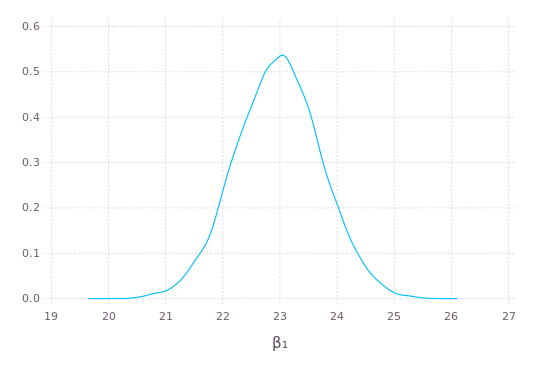

In [8]:
plot(x = penmbstp[:β₁], Geom.density(), Guide.xlabel("β₁"))

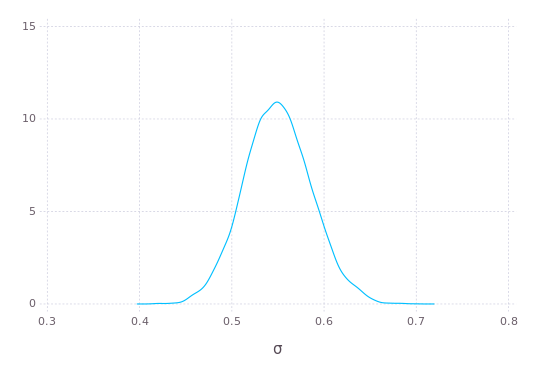

In [9]:
plot(x = penmbstp[:σ], Geom.density(), Guide.xlabel("σ"))

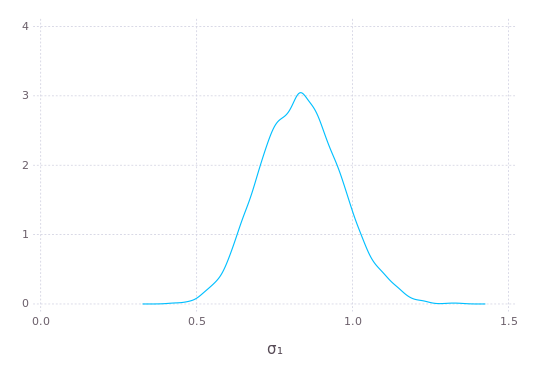

In [10]:
plot(x = penmbstp[:σ₁], Geom.density(), Guide.xlabel("σ₁"))

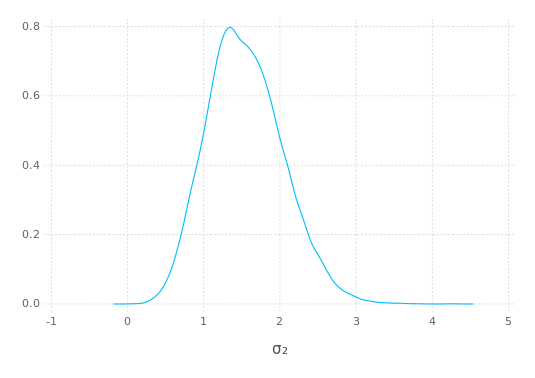

In [11]:
plot(x = penmbstp[:σ₂], Geom.density(), Guide.xlabel("σ₂"))

A profile zeta plot (Fig. [fig:fm03prplot]) for the parameters in model

![Profile zeta plot of the parameters in model .](figure/fm03prplot-1)

[fig:fm03prplot]

leads to conclusions similar to those from Fig. [fig:fm1prof] for model in the previous chapter. The fixed-effect parameter, $\beta_1$, for the constant term has symmetric intervals and is over-dispersed relative to the normal distribution. The logarithm of $\sigma$ has a good normal approximation but the standard deviations of the random effects, $\sigma_1$ and $\sigma_2$, are skewed. The skewness for $\sigma_2$ is worse than that for $\sigma_1$, because the estimate of $\sigma_2$ is less precise than that of $\sigma_1$, in both absolute and relative senses. For an absolute comparison we compare the widths of the confidence intervals for these parameters.
```
                     2.5 %     97.5 %
    .sig01       0.6335658  1.1821040
    .sig02       1.0957893  3.5562919
    .sigma       0.4858454  0.6294535
    (Intercept) 21.2666274 24.6778176
```
In a relative comparison we examine the ratio of the endpoints of the interval divided by the estimate.
```

               2.5 %   97.5 %
    .sig01 0.7492746 1.397993
    .sig02 0.6188634 2.008469
```

The lack of precision in the estimate of $\sigma_2$ is a consequence of only having 6 distinct levels of the factor. The factor, on the other hand, has 24 distinct levels. In general it is more difficult to estimate a measure of spread, such as the standard deviation, than to estimate a measure of location, such as a mean, especially when the number of levels of the factor is small. Six levels are about the minimum number required for obtaining sensible estimates of standard deviations for simple, scalar random effects terms.

The profile pairs plot (Fig. [fig:fm03prpairs])

![Profile pairs plot for the parameters in model fit to the data.](figure/fm03prpairs-1)

[fig:fm03prpairs]

shows patterns similar to those in Fig. [fig:fm1profpair] for pairs of parameters in model fit to the data. On the $\zeta$ scale (panels below the diagonal) the profile traces are nearly straight and orthogonal with the exception of the trace of $\zeta(\sigma_2)$ on $\zeta(\beta_0)$ (the horizontal trace for the panel in the $(4,2)$ position). The pattern of this trace is similar to the pattern of the trace of $\zeta(\sigma_1)$ on $\zeta(\beta_1)$ in Fig. [fig:fm1profpair]. Moving $\beta_0$ from its estimate, $\widehat{\beta}_0$, in either direction will increase the residual sum of squares. The increase in the residual variability is reflected in an increase of one or more of the dispersion parameters. The balanced experimental design results in a fixed estimate of $\sigma$ and the extra apparent variability must be incorporated into $\sigma_1$ or $\sigma_2$.

Contours in panels of parameter pairs on the original scales (i.e. panels above the diagonal) can show considerable distortion from the ideal elliptical shape. For example, contours in the $\sigma_2$ versus $\sigma_1$ panel (the $(1,2)$ position) and the $\log(\sigma)$ versus $\sigma_2$ panel (in the $(2,3)$ position) are dramatically non-elliptical. However, the distortion of the contours is not due to these parameter estimates depending strongly on each other. It is almost entirely due to the choice of scale for $\sigma_1$ and $\sigma_2$. When we plot the contours on the scale of $\log(\sigma_1)$ and $\log(\sigma_2)$ instead (Fig. [fig:lpr03pairs])

![Profile pairs plot for the parameters in model fit to the data. In this plot the parameters $\sigma_1$ and $\sigma_2$ are on the scale of the natural logarithm, as is the parameter $\sigma$ in this and other profile pairs plots.](figure/fm03lprpairs-1)

[fig:fm03lprpairs]

they are much closer to the elliptical pattern.

Conversely, if we tried to plot contours on the scale of $\sigma_1^2$ and $\sigma_2^2$ (not shown), they would be hideously distorted.

## A Model With Nested Random Effects

In this section we again consider a simple example, this time fitting a model with *nested* grouping factors for the random effects.

### The `Pastes` Data

The third example from Davies (1972) is described as coming from

> deliveries of a chemical paste product contained in casks where, in addition to sampling and testing errors, there are variations in quality between deliveries …As a routine, three casks selected at random from each delivery were sampled and the samples were kept for reference. …Ten of the delivery batches were sampled at random and two analytical tests carried out on each of the 30 samples.

The structure and summary of the data object are

In [12]:
pastes = Feather.read(joinpath(datadir, "Pastes.feather"), nullable = false);
names(pastes)

4-element Array{Symbol,1}:
 :strength
 :batch   
 :cask    
 :sample  

As stated in the description in Davies (1972), there are 30 samples, three from each of the 10 delivery batches. We have labelled the levels of the `sample` factor with the label of the `batch` factor followed by `a`, `b` or `c` to distinguish the three samples taken from that batch.

In [13]:
freqtable(convert(Vector{String}, pastes[:batch]), 
    convert(Vector{String}, pastes[:sample]))

10×30 Named Array{Int64,2}
Dim1 ╲ Dim2 │ A:a  A:b  A:c  B:a  B:b  B:c  …  I:a  I:b  I:c  J:a  J:b  J:c
────────────┼──────────────────────────────────────────────────────────────
A           │   2    2    2    0    0    0  …    0    0    0    0    0    0
B           │   0    0    0    2    2    2       0    0    0    0    0    0
C           │   0    0    0    0    0    0       0    0    0    0    0    0
D           │   0    0    0    0    0    0       0    0    0    0    0    0
E           │   0    0    0    0    0    0       0    0    0    0    0    0
F           │   0    0    0    0    0    0       0    0    0    0    0    0
G           │   0    0    0    0    0    0       0    0    0    0    0    0
H           │   0    0    0    0    0    0       0    0    0    0    0    0
I           │   0    0    0    0    0    0       2    2    2    0    0    0
J           │   0    0    0    0    0    0  …    0    0    0    2    2    2

When plotting the `strength` versus `sample` and in the data we should remember that we have two strength measurements on each of the 30 samples. It is tempting to use the cask designation (‘a’, ‘b’ and ‘c’) to determine, say, the plotting symbol within a `sample`. It would be fine to do this within a batch but the plot would be misleading if we used the same symbol for cask ‘a’ in different batches. There is no relationship between cask ‘a’ in batch ‘A’ and cask ‘a’ in batch ‘B’. The labels ‘a’, ‘b’ and ‘c’ are used only to distinguish the three samples within a batch; they do not have a meaning across batches.

![Strength of paste preparations according to the and the within the batch. There were two strength measurements on each of the 30 samples; three samples each from 10 batches.](figure/Pastesplot-1)

[fig:Pastesplot]

In Fig. [fig:Pastesplot] we plot the two strength measurements on each of the samples within each of the batches and join up the average strength for each sample. The perceptive reader will have noticed that the levels of the factors on the vertical axis in this figure, and in Fig. [fig:Dyestuffdot] and [fig:Penicillindot], have been reordered according to increasing average response. In all these cases there is no inherent ordering of the levels of the covariate such as or . Rather than confuse our interpretation of the plot by determining the vertical displacement of points according to a random ordering, we impose an ordering according to increasing mean response. This allows us to more easily check for structure in the data, including undesirable characteristics like increasing variability of the response with increasing mean level of the response.

In Fig. [fig:Pastesplot] we order the samples within each batch separately then order the batches according to increasing mean strength.

Figure [fig:Pastesplot] shows considerable variability in strength between samples relative to the variability within samples. There is some indication of variability between batches, in addition to the variability induced by the samples, but not a strong indication of a batch effect. For example, batches I and D, with low mean strength relative to the other batches, each contained one sample (I:b and D:c, respectively) that had high mean strength relative to the other samples. Also, batches H and C, with comparatively high mean batch strength, contain samples H:a and C:a with comparatively low mean sample strength. In Sect. [sec:TestingSig2is0] we will examine the need for incorporating batch-to-batch variability, in addition to sample-to-sample variability, in the statistical model.

#### Nested Factors

Because each level of occurs with one and only one level of we say that is *nested within* . Some presentations of mixed-effects models, especially those related to *multilevel modeling*  or *hierarchical linear models* , leave the impression that one can only define random effects with respect to factors that are nested. This is the origin of the terms “multilevel”, referring to multiple, nested levels of variability, and “hierarchical”, also invoking the concept of a hierarchy of levels. To be fair, both those references do describe the use of models with random effects associated with non-nested factors, but such models tend to be treated as a special case.

The blurring of mixed-effects models with the concept of multiple, hierarchical levels of variation results in an unwarranted emphasis on “levels” when defining a model and leads to considerable confusion. It is perfectly legitimate to define models having random effects associated with non-nested factors. The reasons for the emphasis on defining random effects with respect to nested factors only are that such cases do occur frequently in practice and that some of the computational methods for estimating the parameters in the models can only be easily applied to nested factors.

This is not the case for the methods used in the package. Indeed there is nothing special done for models with random effects for nested factors. When random effects are associated with multiple factors exactly the same computational methods are used whether the factors form a nested sequence or are partially crossed or are completely crossed. There is, however, one aspect of nested grouping factors that we should emphasize, which is the possibility of a factor that is *implicitly nested* within another factor. Suppose, for example, that the factor was defined as having three levels instead of 30 with the implicit assumption that is nested within . It may seem silly to try to distinguish 30 different batches with only three levels of a factor but, unfortunately, data are frequently organized and presented like this, especially in text books. The factor in the data is exactly such an implicitly nested factor. If we cross-tabulate `cask` and `batch`
```
        batch
    cask A B C D E F G H I J
       a 2 2 2 2 2 2 2 2 2 2
       b 2 2 2 2 2 2 2 2 2 2
       c 2 2 2 2 2 2 2 2 2 2
```
we get the impression that the and factors are crossed, not nested. If we know that the cask should be considered as nested within the batch then we should create a new categorical variable giving the batch-cask combination, which is exactly what the factor is. A simple way to create such a factor is to use the interaction operator, ‘’, on the factors. It is advisable, but not necessary, to apply to the result thereby dropping unused levels of the interaction from the set of all possible levels of the factor. (An “unused level” is a combination that does not occur in the data.) A convenient code idiom is

or

In a small data set like we can quickly detect a factor being implicitly nested within another factor and take appropriate action. In a large data set, perhaps hundreds of thousands of test scores for students in thousands of schools from hundreds of school districts, it is not always obvious if school identifiers are unique across the entire data set or just within a district. If you are not sure, the safest thing to do is to create the interaction factor, as shown above, so you can be confident that levels of the district:school interaction do indeed correspond to unique schools.

### Fitting a Model With Nested Random Effects

Fitting a model with simple, scalar random effects for nested factors is done in exactly the same way as fitting a model with random effects for crossed grouping factors. We include random-effects terms for each factor, as in

In [14]:
pstsm = fit!(lmm(strength ~ 1 + (1 | sample) + (1 | batch), pastes))

Linear mixed model fit by maximum likelihood
 Formula: strength ~ 1 + (1 | sample) + (1 | batch)
  logLik    -2 logLik     AIC        BIC    
 -123.99723  247.99447  255.99447  264.37184

Variance components:
              Column    Variance  Std.Dev. 
 sample   (Intercept)  8.4336167 2.9040690
 batch    (Intercept)  1.1991777 1.0950697
 Residual              0.6780022 0.8234089
 Number of obs: 60; levels of grouping factors: 30, 10

  Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)   60.0533  0.642136 93.5212  <1e-99


Not only is the model specification similar for nested and crossed factors, the internal calculations are performed according to the methods described in Sect. [sec:definitions] for each model type. Comparing the patterns in the matrices $\Lambda$, $\mathbf Z'\mathbf Z$ and $\mathbf L$ for this model (Fig. [fig:fm04LambdaLimage]) to those in Fig. [fig:fm03LambdaLimage] shows that models with nested factors produce simple repeated structures along the diagonal of the sparse Cholesky factor, $\mathbf L$. This type of structure has the desirable property that there is no “fill-in” during calculation of the Cholesky factor. In other words, the number of non-zeros in $\mathbf L$ is the same as the number of non-zeros in the lower triangle of the matrix being factored, $\Lambda'\mathbf Z'\mathbf Z\Lambda+\mathbf I$ (which, because $\Lambda$ is diagonal, has the same structure as $\mathbf Z'\mathbf
Z$).

### Assessing Parameter Estimates in Model `pstsm`

The parameter estimates are: $\widehat{\sigma_1}=$2.904, the standard deviation of the random effects for `sample`; $\widehat{\sigma_2}=$1.095, the standard deviation of the random effects for `batch`; $\widehat{\sigma}=$0.823, the standard deviation of the residual noise term; and $\widehat{\beta_0}=$60.053, the overall mean response, which is labeled `(Intercept)` in these models.

The estimated standard deviation for `sample` is nearly three times as large as that for `batch`, which confirms what we saw in Fig. [fig:Pastesplot]. Indeed our conclusion from Fig. [fig:Pastesplot] was that there may not be a significant batch-to-batch variability in addition to the sample-to-sample variability.


Plots of the prediction intervals of the random effects (Fig. [fig:fm04ranef])

![95% prediction intervals on the random effects for model fit to the data.](figure/fm04ranef-1)

[fig:fm04ranef]

confirm this impression in that all the prediction intervals for the random effects for contain zero. Furthermore, a bootstrap sample

In [15]:
srand(4321234)
@time pstsbstp = bootstrap(10000, pstsm);

  3.394257 seconds (8.76 M allocations: 208.866 MB, 1.60% gc time)


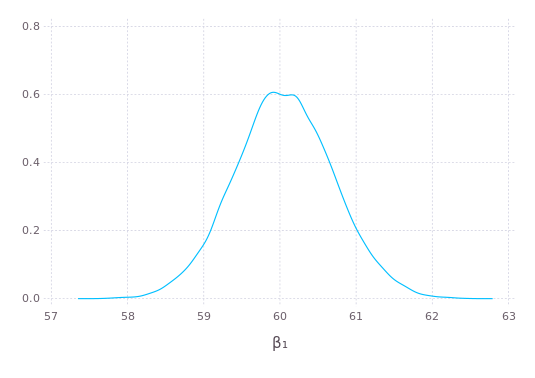

In [16]:
plot(x = pstsbstp[:β₁], Geom.density(), Guide.xlabel("β₁"))

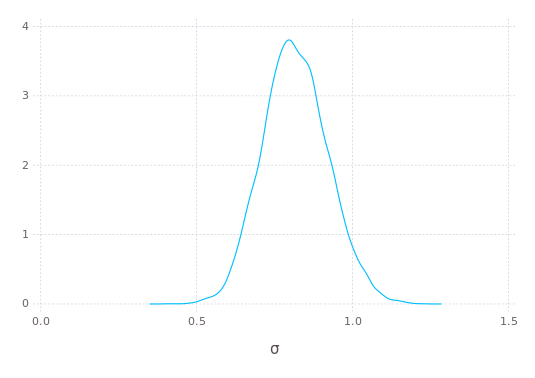

In [17]:
plot(x = pstsbstp[:σ], Geom.density(), Guide.xlabel("σ"))

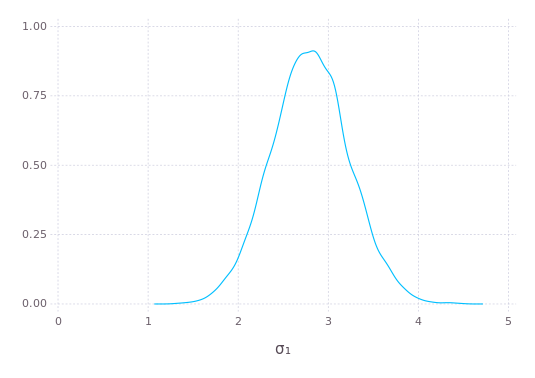

In [18]:
plot(x = pstsbstp[:σ₁], Geom.density(), Guide.xlabel("σ₁"))

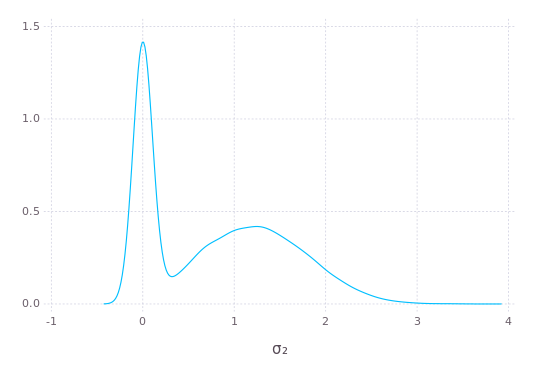

In [19]:
plot(x = pstsbstp[:σ₂], Geom.density(), Guide.xlabel("σ₂"))

and a normal probability plot of

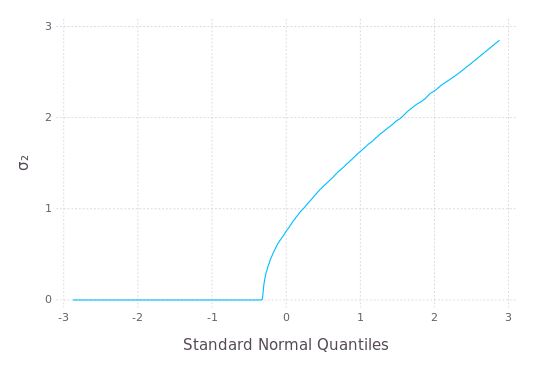

In [20]:
plot(x = zquantiles, y = quantile(pstsbstp[:σ₂], ppt250), Geom.line,
    Guide.xlabel("Standard Normal Quantiles"), Guide.ylabel("σ₂"))

In [21]:
count(x -> x < 1.0e-5, pstsbstp[:σ₂])

3657

Over 1/3 of the bootstrap samples of $\sigma_2$ are zero.  Even a 50% confidence interval on this parameter will extend to zero.  One way to calculate confidence intervals based on a bootstrap sample is sort the sample and consider all the contiguous intervals that contain, say, 95% of the samples then choose the smallest of these.  For example,

In [22]:
hpdinterval(pstsbstp[:σ₂])

2-element Array{Float64,1}:
 0.0    
 2.07348

provides the confidence interval

![Profile zeta plots for the parameters in model .](figure/fm04prplot-1)

[fig:fm04prplot]

shows that the even the 50% profile-based confidence interval on $\sigma_2$ extends to zero.

Because there are several indications that $\sigma_2$ could reasonably be zero, resulting in a simpler model incorporating random effects for only, we perform a statistical test of this hypothesis.

### Testing $H_0:\sigma_2=0$ Versus $H_a:\sigma_2>0$

One of the many famous statements attributed to Albert Einstein is “Everything should be made as simple as possible, but not simpler.” In statistical modeling this *principal of parsimony* is embodied in hypothesis tests comparing two models, one of which contains the other as a special case. Typically, one or more of the parameters in the more general model, which we call the *alternative hypothesis*, is constrained in some way, resulting in the restricted model, which we call the *null hypothesis*. Although we phrase the hypothesis test in terms of the parameter restriction, it is important to realize that we are comparing the quality of fits obtained with two nested models. That is, we are not assessing parameter values per se; we are comparing the model fit obtainable with some constraints on parameter values to that without the constraints.

Because the more general model, $H_a$, must provide a fit that is at least as good as the restricted model, $H_0$, our purpose is to determine whether the change in the quality of the fit is sufficient to justify the greater complexity of model $H_a$. This comparison is often reduced to a *p-value*, which is the probability of seeing a difference in the model fits as large as we did, or even larger, when, in fact, $H_0$ is adequate. Like all probabilities, a p-value must be between 0 and 1. When the p-value for a test is small (close to zero) we prefer the more complex model, saying that we “reject $H_0$ in favor of $H_a$”. On the other hand, when the p-value is not small we “fail to reject $H_0$”, arguing that there is a non-negligible probability that the observed difference in the model fits could reasonably be the result of random chance, not the inherent superiority of the model $H_a$. Under these circumstances we prefer the simpler model, $H_0$, according to the principal of parsimony.

These are the general principles of statistical hypothesis tests. To perform a test in practice we must specify the criterion for comparing the model fits, the method for calculating the p-value from an observed value of the criterion, and the standard by which we will determine if the p-value is “small” or not. The criterion is called the *test statistic*, the p-value is calculated from a *reference distribution* for the test statistic, and the standard for small p-values is called the *level* of the test.

In Sect. [sec:variability] we referred to likelihood ratio tests (LRTs) for which the test statistic is the difference in the deviance. That is, the LRT statistic is $d_0-d_a$ where $d_a$ is the deviance in the more general ($H_a$) model fit and $d_0$ is the deviance in the constrained ($H_0$) model. An approximate reference distribution for an LRT statistic is the $\chi^2_\nu$ distribution where $\nu$, the degrees of freedom, is determined by the number of constraints imposed on the parameters of $H_a$ to produce $H_0$.

The restricted model fit

In [23]:
pstsm1 = fit!(lmm(strength ~ 1 + (1 | sample), pastes))

Linear mixed model fit by maximum likelihood
 Formula: strength ~ 1 + (1 | sample)
  logLik    -2 logLik     AIC        BIC    
 -124.20085  248.40170  254.40170  260.68473

Variance components:
              Column   Variance  Std.Dev.  
 sample   (Intercept)  9.632823 3.10367894
 Residual              0.678000 0.82340753
 Number of obs: 60; levels of grouping factors: 30

  Fixed-effects parameters:
             Estimate Std.Error z value P(>|z|)
(Intercept)   60.0533  0.576536 104.162  <1e-99


is compared to model `pstsm` with

In [24]:
MixedModels.lrt(pstsm1, pstsm)

,Df,Deviance,Chisq,pval
1,3,248.4016998045828,NaN,NaN
2,4,247.99446586294397,0.40723394163882176,0.5233767965913214


which provides a p-value of $0.5234$. Because typical standards for “small” p-values are 5% or 1%, a p-value over 50% would not be considered significant at any reasonable level.

We do need to be cautious in quoting this p-value, however, because the parameter value being tested, $\sigma_2=0$, is on the boundary of set of possible values, $\sigma_2\ge 0$, for this parameter. The argument for using a $\chi^2_1$ distribution to calculate a p-value for the change in the deviance does not apply when the parameter value being tested is on the boundary. As shown in Pinheiro and Bates (2000), the p-value from the $\chi^2_1$ distribution will be “conservative” in the sense that it is larger than a simulation-based p-value would be. In the worst-case scenario the $\chi^2$-based p-value will be twice as large as it should be but, even if that were true, an effective p-value of 26% would not cause us to reject $H_0$ in favor of $H_a$.

### Assessing the Reduced Model, `pstsm1`

A bootstrap sample

In [25]:
@time psts1bstp = bootstrap(10000, pstsm1);

  1.408193 seconds (4.23 M allocations: 101.526 MB, 2.12% gc time)


provides empirical density plots

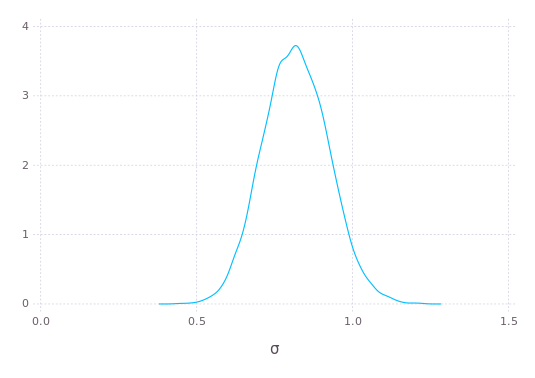

In [26]:
plot(x = psts1bstp[:σ], Geom.density, Guide.xlabel("σ"))

and

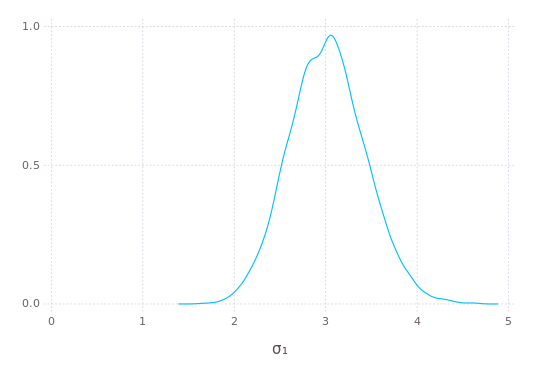

In [27]:
plot(x = psts1bstp[:σ₁], Geom.density, Guide.xlabel("σ₁"))

The profile zeta plots for the remaining parameters in model (Fig. [fig:fm04aprplot])

![Profile zeta plots for the parameters in model .](figure/fm04aprplot-1)

[fig:fm04aprplot]

are similar to the corresponding panels in Fig. [fig:fm04prplot], as confirmed by the numerical values of the confidence intervals.
```
                     2.5 %    97.5 %
    .sig01       2.1579337  4.053589
    .sig02       0.0000000  2.946591
    .sigma       0.6520234  1.085448
    (Intercept) 58.6636504 61.443016
```

```
                     2.5 %    97.5 %
    .sig01       2.4306377  4.122011
    .sigma       0.6520207  1.085448
    (Intercept) 58.8861831 61.220484
```
The confidence intervals on $\log(\sigma)$ and $\beta_0$ are similar for the two models. The confidence interval on $\sigma_1$ is slightly wider in model `pstsm1` than in `pstsm`, because the variability that is attributed to $\sigma_2$ in `pstsm` is incorporated into the variability due to $\sigma_1$ in `pstsm1`.

![Profile pairs plot for the parameters in model fit to the data.](figure/fm04aprpairs-1)

[fig:fm04aprpairs]

The patterns in the profile pairs plot (Fig. [fig:fm04aprpairs]) for the reduced model are similar to those in Fig. [fig:fm1profpair], the profile pairs plot for model .

## A Model With Partially Crossed Random Effects

Especially in observational studies with multiple grouping factors, the configuration of the factors frequently ends up neither nested nor completely crossed. We describe such situations as having *partially crossed* grouping factors for the random effects.

Studies in education, in which test scores for students over time are also associated with teachers and schools, usually result in partially crossed grouping factors. If students with scores in multiple years have different teachers for the different years, the student factor cannot be nested within the teacher factor. Conversely, student and teacher factors are not expected to be completely crossed. To have complete crossing of the student and teacher factors it would be necessary for each student to be observed with each teacher, which would be unusual. A longitudinal study of thousands of students with hundreds of different teachers inevitably ends up partially crossed.

In this section we consider an example with thousands of students and instructors where the response is the student’s evaluation of the instructor’s effectiveness. These data, like those from most large observational studies, are quite unbalanced.

### The `InstEval` Data

The data are from a special evaluation of lecturers by students at the Swiss Federal Institute for Technology–Zürich (ETH–Zürich), to determine who should receive the “best-liked professor” award. These data have been slightly simplified and identifying labels have been removed, so as to preserve anonymity.

The variables

In [28]:
insteval = Feather.read(joinpath(datadir, "InstEval.feather"), 
    nullable = false)
names(insteval)

7-element Array{Symbol,1}:
 :s      
 :d      
 :studage
 :lectage
 :service
 :dept   
 :y      

have somewhat cryptic names. Factor `s` designates the student and `d` the instructor. The factor `dept` is the department for the course and `service` indicates whether the course was a service course taught to students from other departments.

Although the response, `y`, is on a scale of 1 to 5,

In [29]:
freqtable(insteval[:y])

5-element Named Array{Int64,1}
Dim1  │ 
──────┼──────
1     │ 10186
2     │ 12951
3     │ 17609
4     │ 16921
5     │ 15754

it is sufficiently diffuse to warrant treating it as if it were a continuous response.

At this point we will fit models that have random effects for student, instructor, and department (or the combination) to these data. In the next chapter we will fit models incorporating fixed-effects for instructor and department to these data.

In [30]:
@time instm = fit!(lmm(
        y ~ 1 + service + (1 | s) + (1 | d) + (1 | dept), 
        insteval))

  4.212578 seconds (983.03 k allocations: 163.444 MB, 3.93% gc time)


Linear mixed model fit by maximum likelihood
 Formula: y ~ 1 + service + (1 | s) + (1 | d) + (1 | dept)
  logLik    -2 logLik     AIC        BIC    
-1.18860884×10⁵2.37721769×10⁵2.37733769×10⁵2.37788993×10⁵

Variance components:
              Column     Variance     Std.Dev.  
 s        (Intercept)  0.1059731358 0.325535153
 d        (Intercept)  0.2652059910 0.514981544
 dept     (Intercept)  0.0061680499 0.078536933
 Residual              1.3864883209 1.177492387
 Number of obs: 73421; levels of grouping factors: 2972, 1128, 14

  Fixed-effects parameters:
               Estimate Std.Error  z value P(>|z|)
(Intercept)     3.28258 0.0284119  115.536  <1e-99
service      -0.0925886 0.0133832 -6.91828  <1e-11


(Fitting this complex model to a moderately large data set takes a few seconds on a modest desktop computer. Although this is more time than required for earlier model fits, it is a remarkably short time for fitting a model of this size and complexity. In some ways it is remarkable that such a model can be fit at all on such a computer.)

All three estimated standard deviations of the random effects are less than $\widehat{\sigma}$, with $\widehat{\sigma}_3$, the estimated standard deviation of the random effects for `dept`, less than one-tenth of $\widehat{\sigma}$.

It is not surprising that zero is within all of the prediction intervals on the random effects for this factor (Fig. [fig:fm05ranef]). In fact, zero is close to the middle of all these prediction intervals. However, the p-value for the LRT of $H_0:\sigma_3=0$ versus $H_a:\sigma_3>0$

`         `

    Data: InstEval
    Models:
    fm05a: y ~ 1 + (1 | s) + (1 | d)
    fm05: y ~ 1 + (1 | s) + (1 | d) + (1 | dept:service)
          Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
    fm05a  4 237786 237823 -118889   237778                         
    fm05   5 237663 237709 -118827   237653 124.43      1  < 2.2e-16

is highly significant. That is, we have very strong evidence that we should reject $H_0$ in favor of $H_a$.

The seeming inconsistency of these conclusions is due to the large sample size ($n=73421$). When a model is fit to a very large sample even the most subtle of differences can be highly “statistically significant”. The researcher or data analyst must then decide if these terms have practical significance, beyond the apparent statistical significance.

The large sample size also helps to assure that the parameters have good normal approximations. We could profile this model fit but doing so would take a very long time and, in this particular case, the analysts are more interested in a model that uses fixed-effects parameters for the instructors, which we will describe in the next chapter.

We could pursue other mixed-effects models here, such as using the factor and not the interaction to define random effects, but we will revisit these data in the next chapter and follow up on some of these variations there.

![Image of the sparse Cholesky factor, $\mathbf L$, from model ](figure/Multiple-fm05Limage)

[fig:fm05Limage]

### Structure of $\mathbf L$ for model `fm05`

Before leaving this model we examine the sparse Cholesky factor, $\mathbf
L$, (Fig. [fig:fm05Limage]), which is of size $4128\times4128$. Even as a sparse matrix this factor requires a considerable amount of memory,

    8283328 bytes

`   `

    [1] 7.9

but as a triangular dense matrix it would require nearly 10 times as much. There are $(4128\times 4129)/2$ elements on and below the diagonal, each of which would require 8 bytes of storage. A packed lower triangular array would require

`       `

    [1] 65.01965

megabytes. The more commonly used full rectangular storage requires

`     `

    [1] 130.0078

megabytes of storage.

The number of nonzero elements in this matrix that must be updated for each evaluation of the deviance is

` `

    [1] 566960

Comparing this to $8.522256\times 10^{6}$, the number of elements that must be updated in a dense Cholesky factor, we can see why the sparse Cholesky factor provides a much more efficient evaluation of the profiled deviance function.

Chapter Summary
---------------

A simple, scalar random effects term in an model formula is of the form , where is an expression whose value is the *grouping factor* of the set of random effects generated by this term. Typically, is simply the name of a factor, such as in the terms or in the examples in this chapter. However, the grouping factor can be the value of an expression, such as in the last example.

Because simple, scalar random-effects terms can differ only in the description of the grouping factor we refer to configurations such as crossed or nested as applying to the terms or to the random effects, although it is more accurate to refer to the configuration as applying to the grouping factors.

A model formula can include several such random effects terms. Because configurations such as nested or crossed or partially crossed grouping factors are a property of the data, the specification in the model formula does not depend on the configuration. We simply include multiple random effects terms in the formula specifying the model.

One apparent exception to this rule occurs with implicitly nested factors, in which the levels of one factor are only meaningful within a particular level of the other factor. In the data, levels of the factor are only meaningful within a particular level of the factor. A model formula of
```
strength ~ 1 + (1 | cask) + (1 | batch)
```
would result in a fitted model that did not appropriately reflect the sources of variability in the data. Following the simple rule that the factor should be defined so that distinct experimental or observational units correspond to distinct levels of the factor will avoid such ambiguity.

For convenience, a model with multiple, nested random-effects terms can be specified as
```
strength ~ 1 + (1 | batch/cask)
```
which internally is re-expressed as
```
strength ~ 1 + (1 | batch) + (1 | batch:cask)
```
We will avoid terms of the form , preferring instead an explicit specification with simple, scalar terms based on unambiguous grouping factors.

The data, described in Sec. [sec:InstEval], illustrate some of the characteristics of the real data to which mixed-effects models are now fit. There is a large number of observations associated with several grouping factors; two of which, student and instructor, have a large number of levels and are partially crossed. Such data are common in sociological and educational studies but until now it has been very difficult to fit models that appropriately reflect such a structure. Much of the literature on mixed-effects models leaves the impression that multiple random effects terms can only be associated with nested grouping factors. The resulting emphasis on hierarchical or multilevel configurations is an artifact of the computational methods used to fit the models, not the models themselves.

The parameters of the models fit to small data sets have properties similar to those for the models in the previous chapter. That is, profile-based confidence intervals on the fixed-effects parameter, $\beta_0$, are symmetric about the estimate but overdispersed relative to those that would be calculated from a normal distribution and the logarithm of the residual standard deviation, $\log(\sigma)$, has a good normal approximation. Profile-based confidence intervals for the standard deviations of random effects ($\sigma_1$, $\sigma_2$, etc.) are symmetric on a logarithmic scale except for those that could be zero.

Another observation from the last example is that, for data sets with a very large numbers of observations, a term in a model may be “statistically significant” even when its practical significance is questionable.

Exercises
---------

These exercises use data sets from the package for . Recall that to access a particular data set, you must either attach the package

or load just the one data set

`   `

We begin with exercises using the `ergostool` data from the `nlme` package. The analysis and graphics in these exercises is performed in Chap. [chap:Covariates]. The purpose of these exercises is to see if you can use the material from this chapter to anticipate the results quoted in the next chapter.

1. Check the documentation, the structure () and a summary of the data from the package. (If you are familiar with the Star Trek television series and movies, you may want to speculate about what, exactly, the “Borg scale” is.) Are these factors are nested, partially crossed or completely crossed. Is this a replicated or an unreplicated design?

2. Create a plot, similar to Fig. [fig:Penicillindot], showing the effort by subject with lines connecting points corresponding to the same stool types. Order the levels of the factor by increasing average .

3. The experimenters are interested in comparing these specific stool types. In the next chapter we will fit a model with fixed-effects for the factor and random effects for , allowing us to perform comparisons of these specific types. At this point fit a model with random effects for both and . What are the relative sizes of the estimates of the standard deviations, $\widehat{\sigma}_1$ (for ), $\widehat{\sigma}_2$ (for ) and $\widehat{\sigma}$ (for the residual variability)?

4. Refit the model using maximum likelihood. Check the parameter estimates and, in the case of the fixed-effects parameter, $\beta_0$, its standard error. In what ways have the parameter estimates changed? Which parameter estimates have not changed?

5. Profile the fitted model and construct 95% profile-based confidence intervals on the parameters. (Note that you will get the same profile object whether you start with the REML fit or the ML fit. There is a slight advantage in starting with the ML fit.) Is the confidence interval on $\sigma_1$ close to being symmetric about its estimate? Is the confidence interval on $\sigma_2$ close to being symmetric about its estimate? Is the corresponding interval on $\log(\sigma_1)$ close to being symmetric about its estimate?

6. Create the profile zeta plot for this model. For which parameters are there good normal approximations?

7. Create a profile pairs plot for this model. Comment on the shapes of the profile traces in the transformed ($\zeta$) scale and the shapes of the contours in the original scales of the parameters.

8. Create a plot of the 95% prediction intervals on the random effects for using (Substitute the name of your fitted model for in the call to .) Is there a clear winner among the stool types? (Assume that lower numbers on the Borg scale correspond to less effort).

9. Create a plot of the 95% prediction intervals on the random effects for .

10. Check the documentation, the structure () and a summary of the data from the package. Use a cross-tabulation to discover whether and are nested, partially crossed or completely crossed.

11. Fit a model of the in the data with random effects for , and .

12. Plot the prediction intervals for each of the three sets of random effects.

13. Profile the parameters in this model. Create a profile zeta plot. Does including the random effect for appear to be warranted. Does your conclusion from the profile zeta plot agree with your conclusion from examining the prediction intervals for the random effects for ?

14. Refit the model without random effects for . Perform a likelihood ratio test of $H_0:\sigma_3=0$ versus $H_a:\sigma_3>0$. Would you reject $H_0$ in favor of $H_a$ or fail to reject $H_0$? Would you reach the same conclusion if you adjusted the p-value for the test by halving it, to take into account the fact that 0 is on the boundary of the parameter region?

15. Profile the reduced model (i.e. the one without random effects for ) and create profile zeta and profile pairs plots. Can you explain the apparent interaction between $\log(\sigma)$ and $\sigma_1$? (This is a difficult question.)